## Cyberpunk 2077 Steam Reviews NLP Analysis  

## Table of contents
1. [Introduction](#introduction)
2. [Goals](#goals)
3. [Data Cleaning and Exploratory Data Analysis](#EDA)
4. [Assigning patch to reviews](#patch)
5. [Positive Reviews by Patch](#revpatch)
6. [Text-cleanig](#text-cleaning)
7. [Keyword Analysis](#keyword)
8. [Topic Modeling](#topic)
9. [Tech issues](#tech-issues)
10. [Review classifier model](#model)

## 1. Introduction <a name="introduction"></a>

Cyberpunk 2077 developed by CD Projekt Red, is a groundbreaking open-world RPG set in the futuristic metropolis of Night City. Released in December 2020, the game immerses players in a dystopian world where advanced technology and societal fragmentation coexist. It offers a narrative-driven experience with deep character customization and impactful player choices. Despite high anticipation due to CD Projekt Red's reputation, the game's launch was met with mixed reactions, primarily due to technical issues on various platforms. 

My main goal for this analysis is to assess how the perception of Cyberpunk 2077 has evolved over time and try to uncover as many insights from the data as possible.

## 2. Goals for the Analysis<a name="goals"></a>

- Assesment of positive to negative feedback ratio  
- Identifying trends around major updates  
- Identifying predominant keywords in positive and negative reviews  
- Identifying most important review topics covered in reviews across all major patches of the game  
- Quantifying the frequency of technical issue related discussions  
- **BONUS** Building Review classifier model  

## 3. Data Loading Cleaning and Exploratory Data Analysis<a name="EDA"></a>

In [229]:
from wordcloud import WordCloud
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime as dt
# NLP
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kamil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kamil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kamil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [230]:
# Loading the data
# To get the data you will have to download it separately from kaggle or use the steam-api to pull the data yourself
# https://www.kaggle.com/datasets/kamilneumann/cyberpunk-2077-steam-reviews/data

df = pd.read_csv(

    "C:\Cyberpunk2077NLP\cyberpunk2077_all_reviews.csv", low_memory=False)

In [231]:
# Identifying issues with data, cell commented for readability
# Null values
# df.isnull().sum()
# Column Types
# df.dtypes
# df['review'].head(10)

Issues:  
- Unnamed: 0 - unnecessary index column  
- Duplicated column - playtime_at_review.1 and play_time_at_review, the first one contains only null values  
- 4 columns related to timestamp of the review, since we have only the latest form of the review we will assume the "updated" date as creation date  
- 2065 empty reviews = 0,003 % of the reviews, we will drop these  
- Dataframe contains a lot of additional information that won't be neccessary for our data analysis  
- Wrong datatypes  
- Reviews contain a lot of unnecessary signs/elements  

In [232]:
df['playtime_at_review'] = df['playtime_at_review.1']
df = df[df['review'].str.len() >= 5]
# not all of the columns listed below will be relevant for our analysis
# I am leaving some of them in my dataframe in case someone wants to use
# them for a different kind of analysis
relevant_columns = ['language', 'review', 'updated', 'voted_up',
                    'votes_up', 'votes_funny', 'steam_purchase', 'playtime_at_review']
df = df[relevant_columns]
df['review'] = df['review'].astype(str)
df = df.reset_index(drop=True)
df['updated'] = pd.to_datetime(df['updated'])
df['voted_up'] == df['voted_up'].astype(int)

0         True
1         True
2         True
3         True
4         True
          ... 
612375    True
612376    True
612377    True
612378    True
612379    True
Name: voted_up, Length: 612380, dtype: bool

In [293]:
# Polarity
df['voted_up'].value_counts()

voted_up
True     493033
False    119347
Name: count, dtype: int64

In [304]:
# Reviews length
# We will use logarithmic scale since our reviews vary from very short messages to full reviews

df['length'] = df['review'].apply(len)
df['length'].describe()

count    612380.00000000
mean        271.13858552
std         674.34110170
min           5.00000000
25%          19.00000000
50%          61.00000000
75%         219.00000000
max        8000.00000000
Name: length, dtype: float64

## 4. Assigning patch to reviews  <a name="patch"></a>

In [234]:
# Source:https://cyberpunk.fandom.com/wiki/Category:Cyberpunk_2077_Patches
patches_dict = {'1.1': '22.01.2021',
                '1.2': '29.03.2021',
                '1.3': '18.08.2021',
                '1.5': '15.02.2022',
                '1.6': '06.09.2022',
                '2.0': '21.09.2023',
                '2.1': '05.12.2023'}

for patch in patches_dict:
    patches_dict[patch] = pd.to_datetime(patches_dict[patch], dayfirst=True)


def assign_patch(review_date):
    latest_patch = "1.0"
    for patch, date in patches_dict.items():
        if review_date >= date:
            latest_patch = patch
    return latest_patch


df['patch'] = df['updated'].apply(assign_patch)

In [294]:
#
df['patch'].value_counts()

patch
1.0    282070
1.6    118228
1.3     60451
2.0     58190
1.5     32937
1.2     27359
1.1     27278
2.1      5867
Name: count, dtype: int64

## 5. Positive Reviews % by Patch <a name="revpatch"></a>

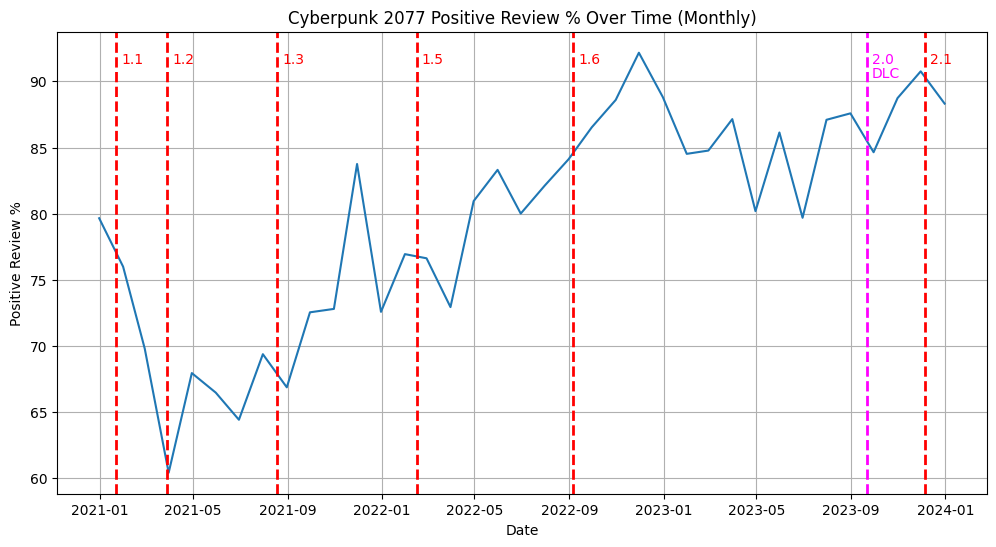

In [235]:
feedback_ratio = df.resample('M', on='updated')['voted_up'].mean() * 100

plt.figure(figsize=(12, 6))
sns.lineplot(data=feedback_ratio)
for patch, date in patches_dict.items():
    if patch == "2.0":
        plt.axvline(pd.to_datetime(date),
                    color='magenta', linestyle='--', lw=2)
        plt.text(pd.to_datetime(date) + dt.timedelta(days=7),
                 feedback_ratio.max(), patch, color='magenta', verticalalignment='top')
        plt.text(pd.to_datetime(date) + dt.timedelta(days=7),
                 feedback_ratio.max()-1, "DLC", color='magenta', verticalalignment='top')
    else:
        plt.axvline(pd.to_datetime(date), color='red', linestyle='--', lw=2)
        plt.text(pd.to_datetime(date) + dt.timedelta(days=7),
                 feedback_ratio.max(), patch, color='red', verticalalignment='top')

plt.title('Cyberpunk 2077 Positive Review % Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Positive Review %')
plt.grid(True)
plt.show()

C:\Users\kamil\AppData\Local\Temp\ipykernel_23984\18173451.py:9: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  ax = sns.barplot(x=positive_reviews_perc.index, y=positive_reviews_perc.values, palette=custom_palette, hue=positive_reviews_perc.values)


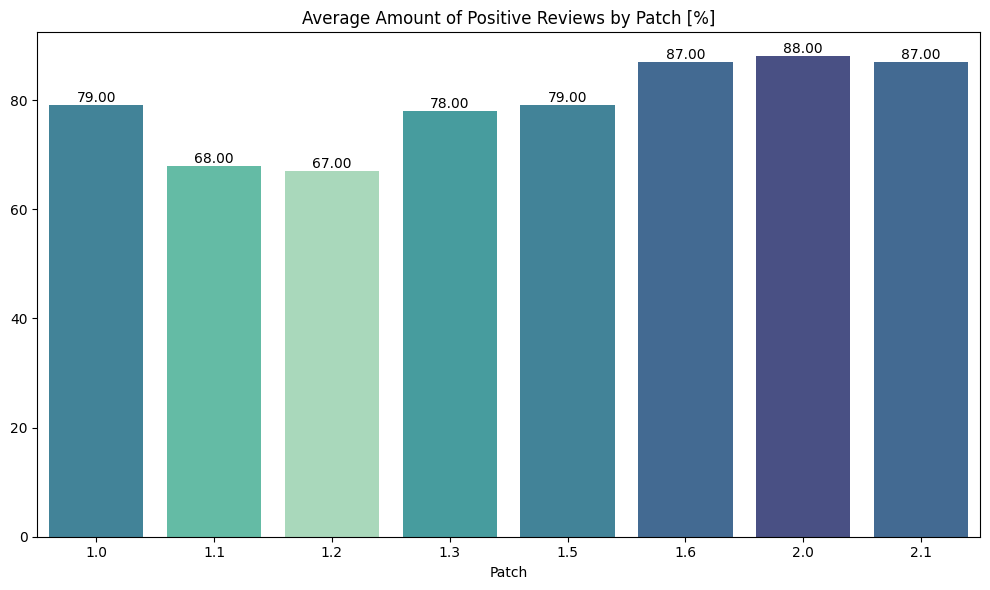

In [236]:
# Positive Reviews Ratio by patch
# ax = df.groupby('patch')['voted_up'].mean().round(2).plot(kind="bar")
# ax.bar_label(ax.containers[0])

positive_reviews_perc = df.groupby('patch')['voted_up'].mean().round(2)*100

plt.figure(figsize=(10, 6))
custom_palette = sns.color_palette(
    "mako_r", n_colors=len(positive_reviews_perc))
ax = sns.barplot(x=positive_reviews_perc.index, y=positive_reviews_perc.values,
                 palette=custom_palette, hue=positive_reviews_perc.values)
ax.get_legend().remove()
ax.set_xlabel("Patch")
plt.title("Average Amount of Positive Reviews by Patch [%]")
plt.tight_layout()
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x(
        ) + p.get_width() / 2., p.get_height()), ha='center', va='bottom')
plt.show()

- Following the game's initial positive reception upon release (with 80% of reviews being positive), there appears to have been a sharp decline until the release of patch 1.2.
- General upward trend: Starting from release of patch 1.2 there appears to be a general upward trend in the ratio, suggesting that over time, the perception of the game has improved among players  
- Phantom Liberty DLC patch 2.0 was the best-performing patch. 
- Highest rating improvements were observed after patch 1.3 and 1.6  

## 6. Text cleaning <a name="text-cleaning"></a>

In [237]:
# Source:https://www.kaggle.com/code/danielbeltsazar/steam-games-reviews-analysis-sentiment-analysis

# stop=set(stopwords.words("english"))
stemmer = PorterStemmer()
lemma = WordNetLemmatizer()


def clean(review):
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', review)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result


def remove_num(texts):
    output = re.sub(r'\d+', '', texts)
    return output


def remove_emoji(x):
    regrex_pattern = re.compile(pattern="["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'', x)


def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string


def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string


def remove_punctuation(text):
    final = "".join(u for u in text if u not in (
        "?", ".", ";", ":",  "!", '"', ','))
    return final


def remove_stopword(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)


def Stemming(text):
    stem = []
    stopword = stopwords.words('english')
    snowball_stemmer = SnowballStemmer('english')
    word_tokens = nltk.word_tokenize(text)
    stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
    stem = ' '.join(stemmed_word)
    return stem


def Lemmatizing(text):
    lemmatized_output = ' '.join([lemma.lemmatize(w) for w in text])
    return lemmatized_output

In [238]:
def cleanup_reviews(df, review, stemming=False):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(remove_emoji)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)

## 7. Keyword Analysis <a name="keyword"></a>

In [239]:
# For simplicity we will limit ourselves to english based reviews when it comes to NLP
df_en = df[df['language'] == "english"].reset_index(drop=True)
cleanup_reviews(df_en, 'review')

It's crucial to keep in mind that many words add nothing useful to our analysis when we examine the terms that appear most frequently in our reviews. Words like "game" and "cyberpunk" are almost certain to be the most commonly used ones. To create a chart or a worldcloud that gives us decent information we should decide whether or not these words should be included.

In [240]:
from collections import Counter
ignore_list = ["cyberpunk", "game", "get", "even", "one"]


def get_most_common_words(reviews, n_words=20):
    tokens = [word_tokenize(review) for review in reviews]
    tokens = [item for sublist in tokens for item in sublist]
    freq = Counter(x for x in tokens if x not in ignore_list)
    return freq.most_common(n_words)


pos_en = df_en[df_en['voted_up'] == 1]
neg_en = df_en[df_en['voted_up'] == 0]

most_common = get_most_common_words(df_en['review'])
most_common_pos = get_most_common_words(pos_en['review'])
most_common_neg = get_most_common_words(neg_en['review'])

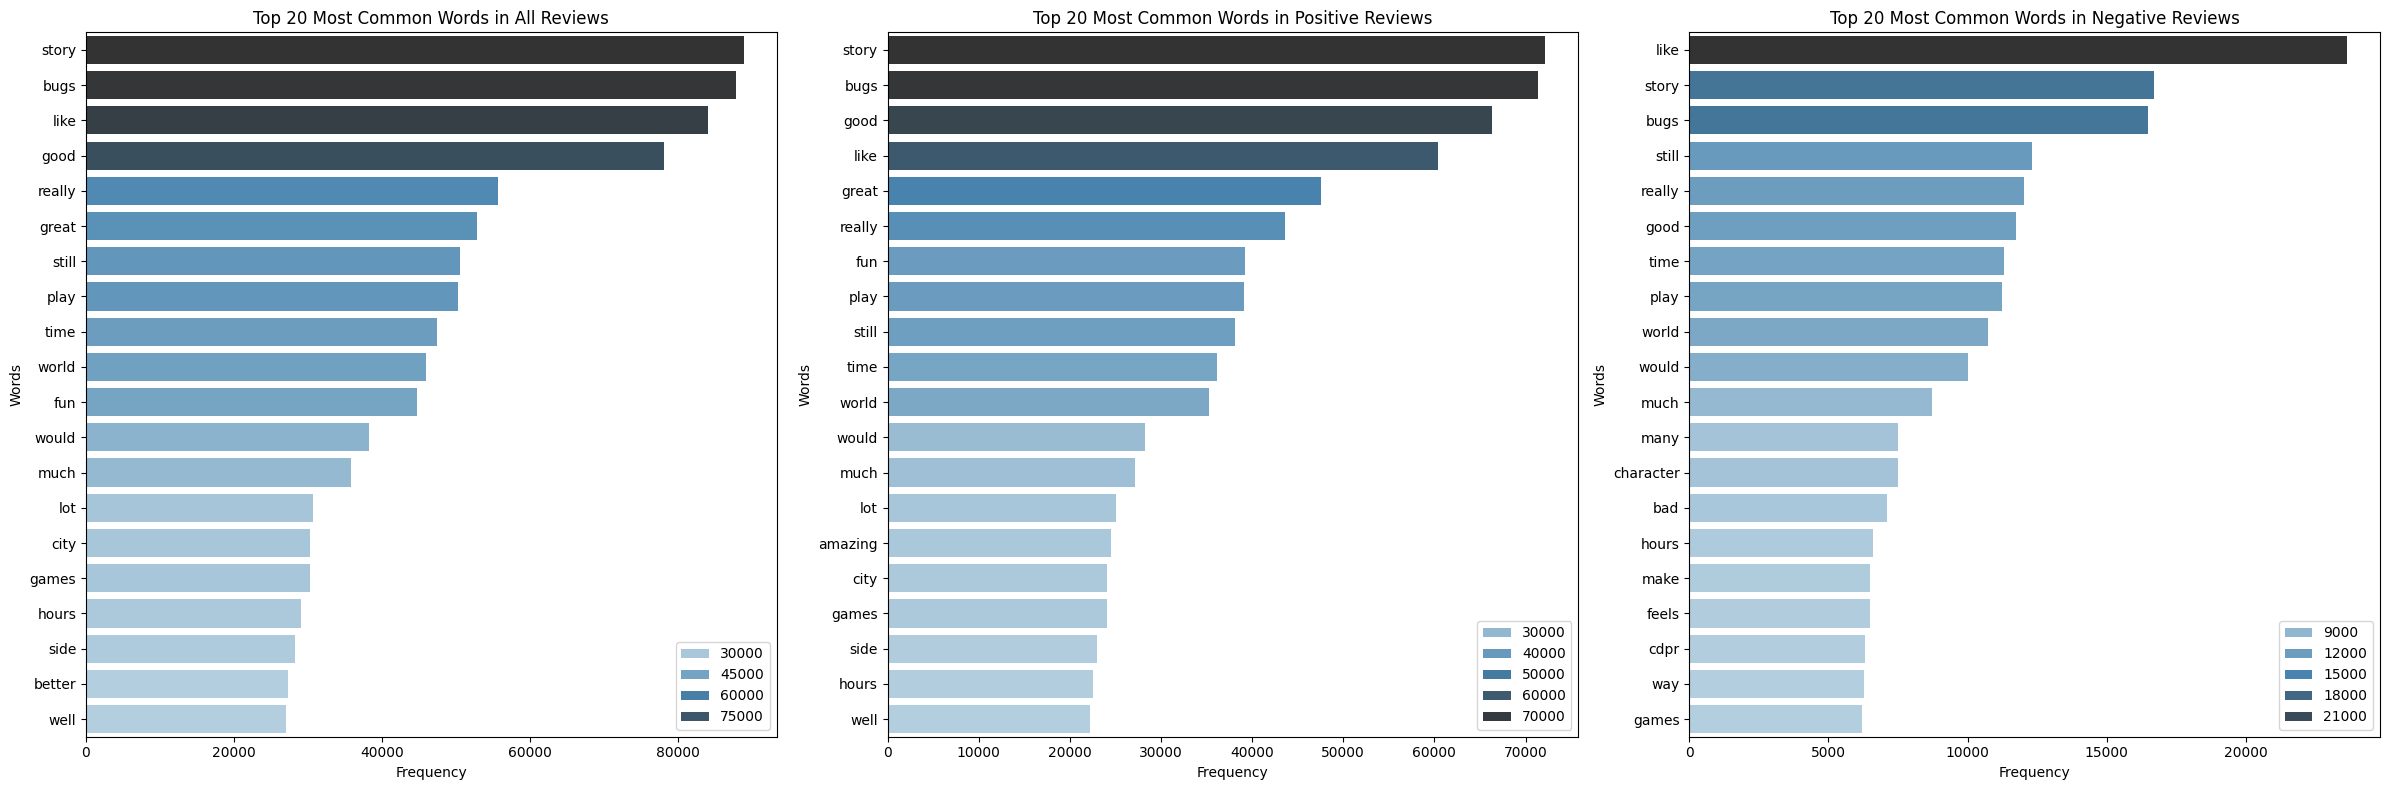

In [241]:
def plot_most_common_words(most_common_words, ax, title=""):
    y, x = zip(*most_common_words)
    sns.barplot(x=x, y=y,  palette='Blues_d', hue=x, ax=ax, orient='h')
    ax.set_title(f"Top 20 Most Common Words in {title}")
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Words')


figs, ax = plt.subplots(1, 3, figsize=(24, 8))
plot_most_common_words(most_common, ax[0], "All Reviews")
plot_most_common_words(most_common_pos, ax[1], "Positive Reviews")
plot_most_common_words(most_common_neg, ax[2], "Negative Reviews")
plt.tight_layout()
plt.show()

Some terms, such as "story," "bugs," and "world," are used frequently all three graphs. This implies that reviewers, regardless of their overall opinion, frequently discuss these subjects. It appears that the most frequently used terms in both positive and negative reviews are similar, making it challenging to determine what aspects of the game players found enjoyable or unsatisfactory. In order to find out more we will move onto topic modeling.  

## 8. Topic Modeling <a name="topic"></a>

In [242]:
# This step might take some time, if you want to track the progress you can change the verbose argument to True
from top2vec import Top2Vec


model = Top2Vec(documents=df_en['review'].tolist(), speed="deep-learn",
                workers=16, verbose=False, embedding_model='universal-sentence-encoder')

c:\Users\kamil\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024-01-03 05:55:38,563 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model


In [243]:
model.hierarchical_topic_reduction(num_topics=7)

[[749,
  481,
  67,
  130,
  146,
  262,
  51,
  34,
  202,
  65,
  71,
  105,
  11,
  97,
  252,
  20,
  689,
  543,
  451,
  260,
  126,
  5,
  87,
  201,
  718,
  139,
  98,
  290,
  3,
  223,
  1,
  229,
  48,
  768,
  187,
  39,
  141,
  9,
  693,
  211,
  12,
  445,
  423,
  173,
  113,
  730,
  615,
  154,
  180,
  1059,
  194,
  131,
  955,
  447,
  819,
  277,
  400,
  419,
  667,
  177,
  42,
  496,
  266,
  92,
  156,
  135,
  380,
  1153,
  167,
  885,
  1105,
  417,
  926,
  0],
 [86,
  28,
  639,
  47,
  101,
  422,
  507,
  232,
  222,
  243,
  318,
  406,
  542,
  676,
  715,
  720,
  788,
  19,
  924,
  613,
  478,
  340,
  216,
  37,
  365,
  124,
  794,
  220,
  114,
  54,
  56,
  579,
  128,
  25,
  933,
  403,
  152,
  381,
  1143,
  611,
  590,
  398,
  76,
  795,
  1092,
  1148,
  60,
  404,
  1068,
  205,
  203,
  606,
  395,
  93,
  176,
  293,
  345,
  106,
  70,
  532,
  296,
  170,
  210,
  219,
  556,
  323,
  975,
  320,
  438,
  546,
  110,
  55,
  534,
 

In [244]:
topic_words, word_scores, topic_nums = model.get_topics(7, reduced=True)
for num in topic_nums:
    print(f"Topic {num+1}")
    print(topic_words[num][:20])
# To create wordcloud, uncomment the code below
# for topic in topic_nums:
#    model.generate_topic_wordcloud(topic, background_color="white", reduced=True)

Topic 1
['replayable' 'replayability' 'arpg' 'goty' 'gamebreaking' 'fortnite'
 'bugfixes' 'openworld' 'unplayable' 'quicksave' 'sidequests' 'glitchy'
 'playable' 'gameplay' 'witcher' 'playthough' 'framerate' 'watchdogs'
 'dishonored' 'gameworld']
Topic 2
['unplayable' 'game' 'playable' 'jeu' 'replayability' 'laggy' 'goty'
 'gaming' 'gameplay' 'underwhelming' 'arpg' 'grindy' 'trainwreck'
 'replayable' 'fanboy' 'replaying' 'hyped' 'lagging' 'fortnite' 'janky']
Topic 3
['buggy' 'bugs' 'bugfixes' 'bugged' 'glitches' 'glitchy' 'gamebreaking'
 'unplayable' 'bug' 'glitching' 'playable' 'glitched' 'patched' 'hotfix'
 'janky' 'hotfixes' 'laggy' 'patching' 'glitch' 'fixes']
Topic 4
['good' 'great' 'awesome' 'nice' 'goood' 'cool' 'nicely' 'amazing'
 'awsome' 'fantastic' 'decent' 'lovely' 'terrific' 'dope' 'fine' 'wow'
 'excellent' 'aight' 'gud' 'super']
Topic 5
['game' 'jeu' 'fun' 'games' 'enjoyable' 'epic' 'glorious' 'entertaining'
 'badass' 'brilliant' 'hilarious' 'replayability' 'awsome' 'amus

<h5>Insights:</h5>
The most prevailing topic in reviews seems to be Role playing aspect of the game.  
Most of the reviewers describe their experience in positive words.  
A lot of players mention bugs, crashes and other technical problems. 
Topic modeling for all of the reviews mostly confirmed our previous findings and summarised words like world,character under the "RPG" flair.  
Looking at the whole corpus of reviews at once doesn't give us information about how the discussion about the game changed, so let's dive into the most important patches:
- 1.0 (release)  
- 1.2 (worst performer)  
- 1.6 (high impact)  
- 2.0 (best performer) 

In [245]:
def get_topic_lists(model, num_topics, reduced=False):
    topics = []
    topic_words, word_scores, topic_nums = model.get_topics(
        num_topics, reduced=reduced)
    for num in topic_nums:
        topics.append(topic_words[num][:10])
    return topics

In [246]:

patch_list = ['1.0', '1.2', '1.6', '2.0']
df_list = []
data_list = []

for patch in patch_list:
    patch_data = df_en[df_en['patch'] == patch]
    pos_reviews = patch_data[patch_data['voted_up'] == 1]['review'].to_list()
    neg_reviews = patch_data[patch_data['voted_up'] == 0]['review'].to_list()

    model_pos = Top2Vec(pos_reviews, speed="deep-learn", workers=16,
                        verbose=False, embedding_model='universal-sentence-encoder')
    model_neg = Top2Vec(neg_reviews, speed="deep-learn", workers=16,
                        verbose=False, embedding_model='universal-sentence-encoder')

    pos_num_topics = model_pos.get_num_topics()
    if pos_num_topics > 5:
        model_pos.hierarchical_topic_reduction(num_topics=5)
        pos_topics = get_topic_lists(model_pos, 5, reduced=True)
    else:
        pos_topics = get_topic_lists(model_pos, pos_num_topics)

    neg_num_topics = model_neg.get_num_topics()
    if neg_num_topics > 5:
        model_neg.hierarchical_topic_reduction(num_topics=5)
        neg_topics = get_topic_lists(model_neg, 5, reduced=True)
    else:
        neg_topics = get_topic_lists(model_neg, neg_num_topics)

    data = {'patch': patch, 'pos_topics': pos_topics, 'neg_topics': neg_topics}
    data_list.append(data)
    temp_df = pd.DataFrame({'patch': patch, 'pos_topics': pos_topics})
    temp_df = temp_df.join(pd.DataFrame(
        {'neg_topics': neg_topics}), how="left")
    df_list.append(temp_df)

c:\Users\kamil\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024-01-03 06:09:17,662 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
c:\Users\kamil\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024-01-03 06:11:08,474 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
c:\Users\kamil\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024-01-03 06:13:32,792 - top2vec - INFO - Downl

In [247]:
# Uncomment and run this cell if you want to save your topics as one dataframe and export it
# topics_df = pd.concat(df_list, axis=0).reset_index(drop=True)
# topics_df.to_csv('topics.csv', index=False)

In [248]:
# In order to see a whole list of word in positive and negative topics we need to change default pandas settings
# My settings are based on a full hd monitor, while using jupyter notebook in VSCode, you might want to adjust these settings in order to improve your experience
# In order to improve your experience I advise you to look at one patch at the time and try to compare it with next one
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 200)
df_list[3]

,patch,pos_topics,neg_topics
0,2.0,"[game, games, replayability, gameplay, replaying, gaming, fun, enjoyable, goty, epic]","[unplayable, playable, game, gameplay, fixes, crashing, glitches, crashes, bugged, buggy]"
1,2.0,"[goty, replayability, unplayable, playable, game, gameplay, replaying, dlc, dlcs, patched]","[fps, graphics, crashing, crashes, bethesda, developers, crash, projekt, gta, glitches]"
2,2.0,"[replayability, cyberpunk, witcher, goty, rpgs, rpg, cdpr, gameplay, fallout, immersive]",NaN
3,2.0,"[good, great, awesome, nice, cool, decent, amazing, fantastic, fine, lovely]",NaN
4,2.0,"[fuck, fuckin, spawn, fucking, crap, fallout, blast, ass, ninja, badass]",NaN


To make sense of this data, we must be clear about our methodology:
The procedures below will be repeated for both positive and negative topics.
1. First, choose subjects that are worth researching.
2. For each patch number where the topic is relevant we should assign the rank of the topic  

Topics in positive reviews:  
Replayability - {'1.0': 1, '1.2': 1, '1.6' : 2, '2.0': 1}  
Bugs {'1.0': 2, '1.2': 5,}  
Fun gameplay {'1.0': 3, '1.2': 2, '1.6' : 1, '2.0': 2}  
Open world RPG {'1.0': 5, '1.2': , '1.6' : 3, '2.0':3 }  
  
Topics in Negative Reviews:  
Unplayable state of the game {'1.0': 1, '1.2': 1, '1.6' : 1, '2.0': 1-2 }  
Framerate issues {'1.0': 2, '2.0': 2}  
Glitches {'1.0': , '1.2': -, '1.6' 2: , '2.0': 1-2}  
Underwhelming (not meeting player's expectations) {'1.0': 5, '1.6' : 5, }  
Gameplay {'1.6': 3}  

Let's summarize our findings:
The most important topics for positive reviews ware replayability, fun gameplay and open world RPG aspects of the game, bugs were also mentioned in reviews of the earlier patches but they fell out of relevance around patch 1.6. Player's satisfaction seemed to go up with each major patch which can be observed both in topic words and player's ratings.

Negative reviews seemed to always mention the unplayable state of the game, crashes and other technical issues which we e were already aware of. The only major find in this part of the analysis is that some players talked about game being "bad", "underwhelming" or "unfinished", which no seems to no longer be the case by patch 2.0.

## 9. Quantifying the frequency of technical issue related discussions <a name="tech-issues"></a>
In orded to find this out we will need to determine if each individual review mentions one of the following topics:
- framerate issues  
- glitches  
- crashes  
- bugs  
- lags  

In [249]:
# I have tried a few approaches and simple word check seems to be one of the most efficient ones
# fuzzyword search - ran too slow
# top2vec - some of our reviews are too short so it's not applicable
# while naive implementation might not be the best solution, it seems to be a sufficient one as long as
# we check if we are looking for most frequently used words that describe the problem
issues = ['bug', 'glitch', 'crash', 'lag', 'buggy',
          'bugs', 'issues', 'glitches', 'broken', 'crashes']


def check_for_topics(body, topics):
    """
    Receives list of words that are considered "topics" and string of text "body"
    Returns 1 if any of the topics in provided list will be found in the text body
    Returns 0 if none of the topics will be found
    """
    for topic in topics:
        if topic in body.split():
            return 1
    return 0


df_en['tech issue'] = df_en['review'].apply(check_for_topics, args=(issues, ))

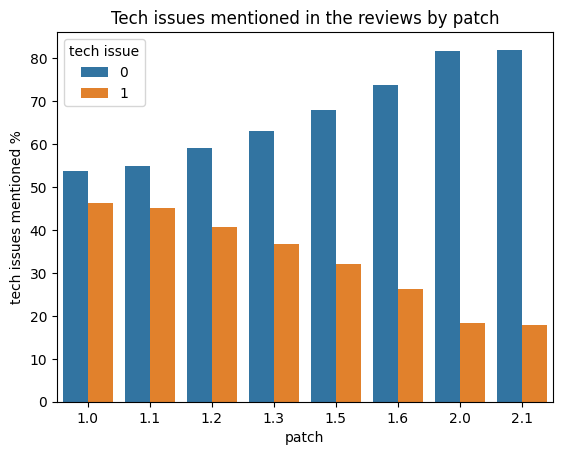

In [314]:
counts = df_en.groupby("patch")['tech issue'].value_counts()
counts = counts.reset_index(name='counts')
total_counts = counts.groupby(
    'patch')['counts'].sum().reset_index(name='total counts')
merged_df = pd.merge(counts, total_counts, on='patch')
counts['tech issues mentioned %'] = merged_df['counts'] / \
    merged_df['total counts'] * 100
sns.barplot(data=counts, x='patch',
            y='tech issues mentioned %', hue='tech issue')
plt.title("Tech issues mentioned in the reviews by patch")
plt.show()

In [292]:
counts[counts['tech issue'] == 1]

,patch,tech issue,counts,tech issues mentioned %
1,1.0,1,58145,46.31001306
3,1.1,1,5448,45.13296330
5,1.2,1,4899,40.80799667
7,1.3,1,8194,36.83689984
9,1.5,1,4971,31.99459355
11,1.6,1,14019,26.23855958
13,2.0,1,5086,18.35438470
15,2.1,1,487,17.98375185


Our previous assumptions were correct, with each patch the amount of reviews discussing technical issues decreased significantly. Starting at over 45 % of the reviews at patch 1.0 down to barely 18 % at patch 2.0.


## 10. Review classification model <a name="model"></a>

In [251]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

You can uncomment the code below if you want to use GridSearchCV to look for better parameters

In [252]:
# X = df_en['review']
# y = df_en['voted_up']
#
# param_grid = {
#    'C': [0.001, 0.01, 0.1, 1, 10],
#    'solver': ['liblinear', 'lbfgs','sag','saga'],
#    'max_iter': [1000],
#    'fit_intercept': [True, False],
#    'class_weight': ['balanced', None]
# }
#
# lr = LogisticRegression()
# tfidf_vectorizer = TfidfVectorizer(max_features=10000)
# grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,)
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# X_test_tfidf = tfidf_vectorizer.transform(X_test)
# grid_search.fit(X_train_tfidf, y_train)
# print("Best Parameters: ", grid_search.best_params_)
# print("Best Accuracy Score: {:.2f}%".format(grid_search.best_score_ * 100))
# print("Best ROC AUC Score: {:.2f}".format(grid_search.best_score_))
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test_tfidf)
# print(classification_report(y_test, y_pred))

# Fitting 5 folds for each of 80 candidates, totalling 400 fits
# Best Parameters:  {'C': 1, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 1000, 'solver': 'lbfgs'}
# Best Accuracy Score: 93.61%
# Best ROC AUC Score: 0.94

In [281]:
# Previously I have skipped few possible parts of data preprocessing such as stemming and lematiziation since
# I've wanted to see the original form of the words. I have tried applying those steps to the data
# but in my experience it didn't improve the results with my current settings

pipeline = Pipeline([
    ('vect', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(solver='lbfgs',
                               fit_intercept=True, class_weight='balanced', C=1, max_iter=1000))
])


X = df_en['review']
y = df_en['voted_up']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=10)
pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba[:, 1])
conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(f"Accuracy Score:{acc}")
print(f"ROC AUC Score:{roc}")
print(conf_matrix)

              precision    recall  f1-score   support

       False       0.57      0.84      0.68      8880
        True       0.97      0.88      0.92     45372

    accuracy                           0.87     54252
   macro avg       0.77      0.86      0.80     54252
weighted avg       0.90      0.87      0.88     54252

Accuracy Score:0.8710646612106466
ROC AUC Score:0.9347793016667819
[[ 7485  1395]
 [ 5600 39772]]


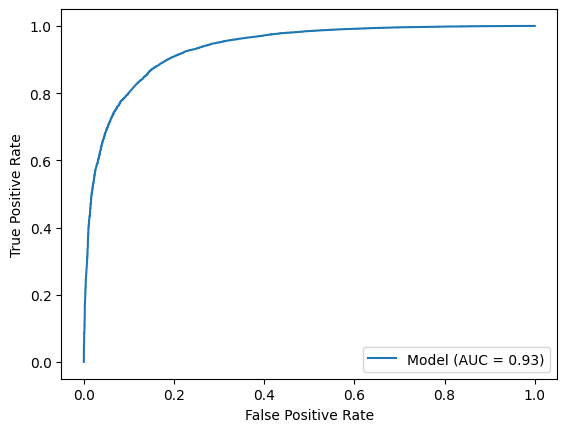

In [282]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Model')
display.plot()
plt.show()

In [283]:
float_y_pred = []
for y in y_pred_proba[:, 1]:
    float_y_pred.append(y)
ydf = pd.DataFrame(list(zip(float_y_pred, y_test, X_test)),
                   columns=['y_pred', 'y', 'review'])
# False Positive
pd.set_option("display.precision", 8)
false_positives = ydf[ydf['y'] == 0].sort_values(by="y_pred", ascending=False)
false_positives.head(5)

,y_pred,y,review
5479,0.99927414,False,amazing game
24766,0.99895186,False,immersive world great characters enjoyable combat
31034,0.99701572,False,great game somewheresomewhere
2358,0.99701572,False,great game
4135,0.99701572,False,great game


In [287]:
# False Negative
false_negatives = ydf[ydf['y'] == 1].sort_values(by="y_pred", ascending=True)
false_negatives.head(5)

,y_pred,y,review
7559,0.00024559,True,still believe spent hours life trying convince game good regardless bugs may may patched game still mediocre best overall gameplay loop generic boring open world completely dead serves nothing emp...
19434,0.00067047,True,boring
44921,0.00067555,True,update game finally good worth itoriginal review long since trash heap released even months patches still buggy mess even stick main story veer paper thin open world night city still encounter ter...
603,0.00205541,True,game crap waste money steam letting change recommendation hopefully someone sees instead
372,0.00209461,True,game doesnt deserve much positive reviews f another company made kind shit game would totaly different story dont waste money garbage game


In [306]:
# Let's see what are our top weighted words in our model

feature_names = pipeline.named_steps['vect'].vocabulary_
coefficients = pipeline.named_steps['clf'].coef_
coef_feature_mapping = dict(zip(feature_names, coefficients[0]))
sorted_feature_names = sorted(coef_feature_mapping, key=lambda x: abs(
    coef_feature_mapping[x]), reverse=True)
features = pd.DataFrame({'Word': sorted_feature_names, 'Coefficient': [
                        coef_feature_mapping[word] for word in sorted_feature_names]})
features.sort_values(by='Coefficient', inplace=True)
print(features.head(5))
print(features.tail(5))

         Word  Coefficient
0   consumers  -7.69534129
4       photo  -6.48977587
7    controls  -5.85943738
8          ck  -5.82968020
10   guessing  -5.81462084
         Word  Coefficient
6        corp   6.21161947
5  restarting   6.48588451
3      bought   6.49869478
2       edges   6.55170414
1    honestly   7.52441315
